# Librerias

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, precision_recall_curve,recall_score, f1_score,  make_scorer
from scipy.stats import ks_2samp, kruskal, chisquare
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import cufflinks as cf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from varclushi import VarClusHi
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pandas as pd
import numpy as np

import autopep8
import os
import warnings
warnings.filterwarnings("ignore")


cf.go_offline()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Carga de datos

In [3]:
path = '/home/david/AMV/Ciencia_Datos/Proyecto_Final_Salary/'

In [4]:
os.listdir(path)

['Proyecto_Figueroa_Contreras_Angel_modulo3.ipynb',
 'proyecto_final_figueroacontrerasangeldavid.ipynb',
 'Modulo 2',
 'mds.pkl',
 'Repostorios.py',
 'Proyecto_Figueroa_Contreras_Angel_modulo2.ipynb',
 'PROYECTO_FINAL.odt',
 'Modulo 3',
 'salary.csv',
 'reveal.js',
 'metricas.pkl',
 'Presentacion.ipynb',
 'isomap.pkl',
 'cluster_salary.pkl',
 '.ipynb_checkpoints',
 'modelo_final.pkl',
 '__pycache__']

In [5]:
df = pd.read_csv(path + 'salary.csv')

# Supervisado 

## Ingenieria de datos

In [6]:
df.shape 

(32561, 15)

In [7]:
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [8]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary'],
      dtype='object')

In [9]:
df.insert(df.shape[1] ,'tgt',np.where(df['salary'].isin([' <=50K']) ,1,0) )

In [10]:
df = df.rename(columns ={'age':'x_age',
                    'fnlwgt':'x_fnlwgt',
                    'education-num':'x_education-num',
                    'capital-gain':'x_capital-gain',
                    'capital-loss':'x_capital-loss',
                    'hours-per-week':'x_hours-per-week'})

In [11]:
df[['tgt']].value_counts()

tgt
1      24720
0       7841
dtype: int64

### Variables discretas

#### Particion de nuestro conjunto de datos para creación de variables mas precisas

In [12]:
tgt = 'tgt'
var = [c for c in df.columns if c!=tgt]

In [13]:
X = df[var].copy()
y = df[tgt].copy()

In [14]:
Xt, Xv, yt, yv = train_test_split(X, y, test_size=.2, random_state=2000)

In [15]:
Xt = Xt.reset_index(drop=True)
yt = yt.reset_index(drop=True)
Xv = Xv.reset_index(drop=True)
yv = yv.reset_index(drop=True)


In [16]:
vard = ['workclass', 'education',  'marital-status', 'occupation', 
        'relationship', 'race', 'sex','native-country']

In [17]:
for c in vard:
    df[c] = df[c].map(lambda x: x.strip())

#### Creación de diccionarios

In [18]:
def probs_dict(X, y, col, event=1):
    
    # 1. Lista de valores (categorías):
    values = list(X[col].unique())
    
    # 2. Creamos el diccionario en donde guardaremos los datos:
    prob_dict = {}
    
    # 3. Calcular los valores:
    aux = X.copy()
    aux['tgt'] = y
    for v in values:
        aux2 = aux.loc[aux[col]==v].copy()
        try:
            prob_dict[v] = aux2['tgt'].value_counts(1)[event]
        except:
            prob_dict[v] = 0
    
    return(prob_dict)

In [19]:
probs_dict(Xt,yt, 'occupation')

{' Craft-repair': 0.7717554953327311,
 ' Sales': 0.7277059223961879,
 ' ?': 0.8949864498644986,
 ' Handlers-cleaners': 0.9365671641791045,
 ' Other-service': 0.9559437903532093,
 ' Prof-specialty': 0.5547820823244553,
 ' Machine-op-inspct': 0.8737373737373737,
 ' Farming-fishing': 0.8770595690747782,
 ' Priv-house-serv': 0.9919354838709677,
 ' Adm-clerical': 0.8646690813302601,
 ' Tech-support': 0.6912568306010929,
 ' Protective-serv': 0.66600790513834,
 ' Exec-managerial': 0.5164767477671697,
 ' Transport-moving': 0.8051643192488263,
 ' Armed-Forces': 0.8571428571428571}

In [20]:
vard_prob_dicts = {}

for d in vard:
    vard_prob_dicts[d] = probs_dict(Xt, yt, d)

In [21]:
def map_dicts(X, columns:list, values_dict:dict, new_col=False, label='x_'):
    
    if new_col:
        for c in columns:
            X[label+c] = X[c].map(values_dict.get(c))
    else:
        for c in columns:
            X[c] = X[c].map(values_dict.get(c))
    return(X)

In [22]:
Xt = map_dicts(Xt, vard, vard_prob_dicts, new_col=True)
Xv = map_dicts(Xv, vard, vard_prob_dicts, new_col=True)

### Explotación variables continuas

In [23]:
var = Xt.filter(like='x_').columns.to_list()

In [24]:
Xt[var]

,x_age,x_fnlwgt,x_education-num,x_capital-gain,x_capital-loss,x_hours-per-week,x_workclass,x_education,x_marital-status,x_occupation,x_relationship,x_race,x_sex,x_native-country
0,28,138269,9,0,0,40,0.781467,0.841209,0.953814,0.771755,0.896583,0.743421,0.692449,0.753726
1,28,200515,10,0,0,40,0.707006,0.807949,0.551401,0.771755,0.549327,0.743421,0.692449,0.753726
2,46,204928,10,0,0,40,0.439866,0.807949,0.551401,0.727706,0.549327,0.743421,0.692449,0.753726
3,49,407495,9,0,0,70,0.894486,0.841209,0.916185,0.894986,0.896583,0.743421,0.692449,0.753726
4,20,281356,9,0,0,40,0.781467,0.841209,0.551401,0.936567,0.549327,0.898148,0.692449,0.753726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,65,207281,10,0,0,16,0.781467,0.807949,0.551401,0.666008,0.549327,0.743421,0.692449,0.753726
26044,29,57423,11,0,0,48,0.781467,0.742857,0.551401,0.873737,0.549327,0.743421,0.692449,0.753726
26045,64,267198,15,0,0,16,0.894486,0.272124,0.551401,0.894986,0.549327,0.743421,0.692449,0.753726
26046,46,340718,7,0,0,40,0.627119,0.947255,0.911361,0.864669,0.896583,0.743421,0.890980,0.753726


In [25]:
Xt.insert(4,'x_age_exp', Xt['x_education-num']/(Xt['x_age'] + Xt['x_education-num']))
Xv.insert(4,'x_age_exp', Xv['x_education-num']/(Xv['x_age'] + Xv['x_education-num']))

In [26]:
Xt.loc[Xt['salary']== ' <=50K'][['x_age_exp']].describe()

,x_age_exp
count,19756.000000
mean,0.222942
std,0.075336
min,0.015152
25%,0.169492
50%,0.222222
75%,0.281250
max,0.437500


In [27]:
Xt.loc[Xt['salary']== ' >50K'][['x_age_exp']].describe()

,x_age_exp
count,6292.000000
mean,0.213443
std,0.053448
min,0.035714
25%,0.174603
50%,0.213115
75%,0.250000
max,0.371429


In [28]:
Xt['salary'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [29]:
def ext_capital(df):
    l = []
    for c in range(len(df)):
        if df['x_capital-gain'][c] ==0 and df['x_capital-loss'][c] ==0 :
            l.append(0)
        elif df['x_capital-gain'][c] ==0 and  df['x_capital-loss'][c] >0 :
            l.append(1)
        elif df['x_capital-gain'][c] > 0 and df['x_capital-loss'][c] ==0  :
            l.append(2)
        else:
            l.append(0)
    df.insert(df.shape[1] ,'x_capital',l )
    

In [30]:
ext_capital(Xt)
ext_capital(Xv)

### Variables finales

In [31]:
var = Xt.filter(like='x_').columns.to_list()

## TAD Preliminar

In [32]:
tad = Xt.merge(yt, right_index=True, left_index=True)

## Analisis Univariado

### Varianza nula

In [33]:
vt = VarianceThreshold()
vt.fit(Xt[var]) 

VarianceThreshold()

In [34]:
sin_varianza = [ v for v,u in zip( var , vt.get_support() ) if not(u)   ]
sin_varianza

[]

### Extremos

array([[<Axes: title={'center': 'x_age'}>,
        <Axes: title={'center': 'x_fnlwgt'}>,
        <Axes: title={'center': 'x_age_exp'}>,
        <Axes: title={'center': 'x_education-num'}>],
       [<Axes: title={'center': 'x_capital-gain'}>,
        <Axes: title={'center': 'x_capital-loss'}>,
        <Axes: title={'center': 'x_hours-per-week'}>,
        <Axes: title={'center': 'x_workclass'}>],
       [<Axes: title={'center': 'x_education'}>,
        <Axes: title={'center': 'x_marital-status'}>,
        <Axes: title={'center': 'x_occupation'}>,
        <Axes: title={'center': 'x_relationship'}>],
       [<Axes: title={'center': 'x_race'}>,
        <Axes: title={'center': 'x_sex'}>,
        <Axes: title={'center': 'x_native-country'}>,
        <Axes: title={'center': 'x_capital'}>]], dtype=object)

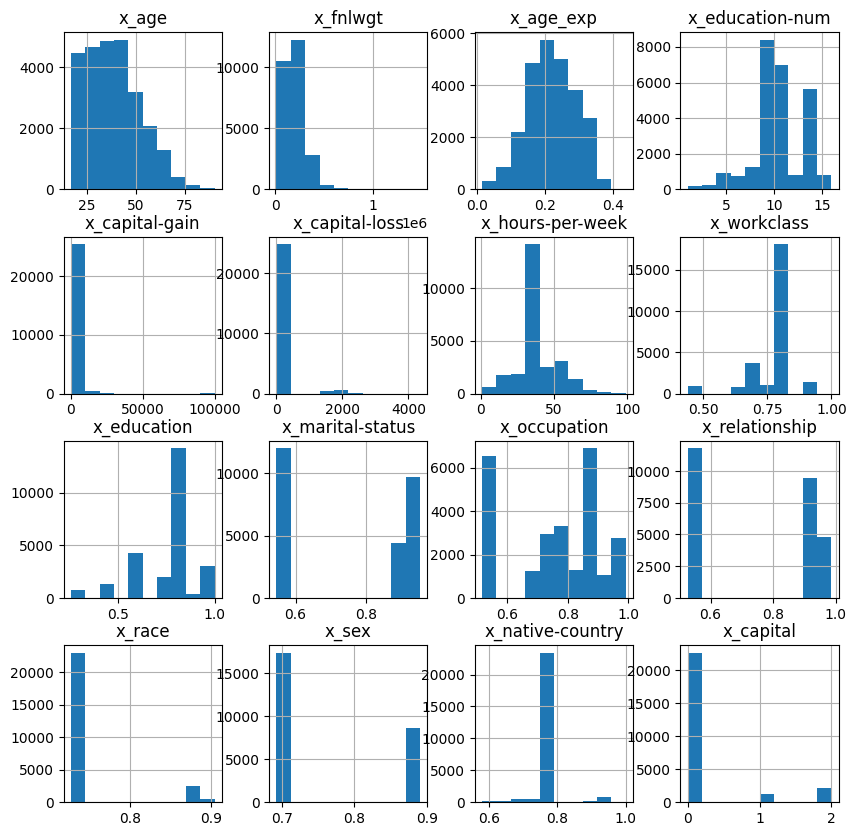

In [35]:
tad[var].hist(figsize=(10,10)) 

In [36]:
ext = tad[var].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index()

for v, li, ls in ext.values:
    tad[f'ol_{v}'] = ( (tad[v]<li) | (tad[v]>ls) ).astype(int)

tad['ext'] = tad.filter(like='ol').max(axis=1)
tad.drop(tad.filter(like='ol_').columns, axis=1, inplace=True )

tad['ext'].value_counts(True)

0    0.901605
1    0.098395
Name: ext, dtype: float64

In [37]:
tad.loc[tad['ext']==1]

,x_age,workclass,x_fnlwgt,education,x_age_exp,x_education-num,marital-status,occupation,relationship,race,sex,x_capital-gain,x_capital-loss,x_hours-per-week,native-country,salary,x_workclass,x_education,x_marital-status,x_occupation,x_relationship,x_race,x_sex,x_native-country,x_capital,tgt,ext
7,23,Local-gov,144165,Bachelors,0.361111,13,Never-married,Prof-specialty,Own-child,Amer-Indian-Eskimo,Male,0,0,30,United-States,<=50K,0.702281,0.581374,0.953814,0.554782,0.986379,0.904000,0.692449,0.753726,0,1,1
13,30,?,159303,Bachelors,0.302326,13,Married-civ-spouse,?,Wife,White,Female,0,0,4,United-States,<=50K,0.894486,0.581374,0.551401,0.894986,0.526570,0.743421,0.890980,0.753726,0,1,1
14,61,Private,120933,Some-college,0.140845,10,Never-married,Priv-house-serv,Not-in-family,White,Female,0,0,40,United-States,<=50K,0.781467,0.807949,0.953814,0.991935,0.896583,0.743421,0.890980,0.753726,0,1,1
30,35,Local-gov,85548,Some-college,0.222222,10,Separated,Adm-clerical,Unmarried,Amer-Indian-Eskimo,Female,0,0,40,United-States,<=50K,0.702281,0.807949,0.937046,0.864669,0.936755,0.904000,0.890980,0.753726,0,1,1
41,43,Private,213844,HS-grad,0.173077,9,Married-AF-spouse,Craft-repair,Wife,Black,Female,0,0,42,United-States,>50K,0.781467,0.841209,0.545455,0.771755,0.526570,0.874406,0.890980,0.753726,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26002,21,Private,243368,Preschool,0.045455,1,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,50,Mexico,<=50K,0.781467,1.000000,0.953814,0.877060,0.896583,0.743421,0.692449,0.943137,0,1,1
26003,44,Local-gov,212665,Some-college,0.185185,10,Married-civ-spouse,Protective-serv,Husband,Black,Male,0,0,99,United-States,<=50K,0.702281,0.807949,0.551401,0.666008,0.549327,0.874406,0.692449,0.753726,0,1,1
26013,48,Private,121253,Bachelors,0.213115,13,Married-spouse-absent,Sales,Unmarried,White,Female,0,2472,70,United-States,>50K,0.781467,0.581374,0.916185,0.727706,0.936755,0.743421,0.890980,0.753726,1,0,1
26039,81,?,106765,Some-college,0.109890,10,Widowed,?,Unmarried,White,Female,0,0,4,United-States,<=50K,0.894486,0.807949,0.911361,0.894986,0.936755,0.743421,0.890980,0.753726,0,1,1


In [38]:
tad = tad.loc[ tad['ext'] == 0 ].drop(['ext'],axis=1)

In [39]:
Xt = tad[var]
yt = tad[tgt]

array([[<Axes: title={'center': 'x_age'}>,
        <Axes: title={'center': 'x_fnlwgt'}>,
        <Axes: title={'center': 'x_age_exp'}>,
        <Axes: title={'center': 'x_education-num'}>],
       [<Axes: title={'center': 'x_capital-gain'}>,
        <Axes: title={'center': 'x_capital-loss'}>,
        <Axes: title={'center': 'x_hours-per-week'}>,
        <Axes: title={'center': 'x_workclass'}>],
       [<Axes: title={'center': 'x_education'}>,
        <Axes: title={'center': 'x_marital-status'}>,
        <Axes: title={'center': 'x_occupation'}>,
        <Axes: title={'center': 'x_relationship'}>],
       [<Axes: title={'center': 'x_race'}>,
        <Axes: title={'center': 'x_sex'}>,
        <Axes: title={'center': 'x_native-country'}>,
        <Axes: title={'center': 'x_capital'}>]], dtype=object)

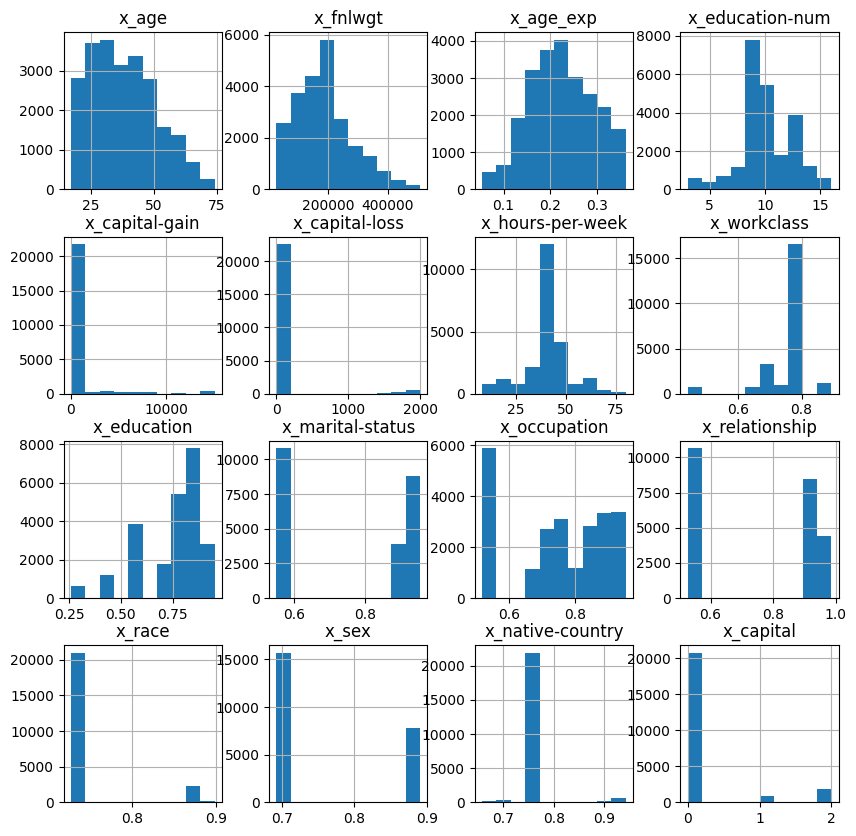

In [40]:
tad[var].hist(figsize=(10,10)) 

## Analisis Bivariado

In [41]:
sns.pairplot(Xt[var].sample(1000))

Error in callback <function flush_figures at 0x7efc6791f0a0> (for post_execute):


KeyboardInterrupt: 

In [42]:
Xt[var].corr()

,x_age,x_fnlwgt,x_age_exp,x_education-num,x_capital-gain,x_capital-loss,x_hours-per-week,x_workclass,x_education,x_marital-status,x_occupation,x_relationship,x_race,x_sex,x_native-country,x_capital
x_age,1.000000,-0.072960,-0.800060,0.074512,0.111256,0.034504,0.133257,-0.160857,-0.127693,-0.371266,-0.155797,-0.376936,-0.029904,-0.092556,-0.071075,0.113831
x_fnlwgt,-0.072960,1.000000,0.037012,-0.035631,0.001380,-0.005032,-0.019522,0.036003,0.029278,0.032845,0.022784,0.032665,0.100800,-0.022813,0.110344,-0.004428
x_age_exp,-0.800060,0.037012,1.000000,0.480244,-0.029446,0.006288,-0.103665,0.082246,-0.369730,0.318757,-0.097788,0.312405,-0.029456,0.102729,-0.077089,-0.041635
x_education-num,0.074512,-0.035631,0.480244,1.000000,0.142367,0.082516,0.162548,-0.148558,-0.922311,-0.089980,-0.480981,-0.113580,-0.090290,-0.007324,-0.189424,0.118047
x_capital-gain,0.111256,0.001380,-0.029446,0.142367,1.000000,-0.048360,0.094468,-0.078214,-0.157423,-0.138386,-0.146455,-0.142904,-0.029139,-0.068395,-0.028476,0.783075
x_capital-loss,0.034504,-0.005032,0.006288,0.082516,-0.048360,1.000000,0.049859,-0.030261,-0.090883,-0.080938,-0.081043,-0.085894,-0.016763,-0.041708,-0.025377,0.290962
x_hours-per-week,0.133257,-0.019522,-0.103665,0.162548,0.094468,0.049859,1.000000,-0.179163,-0.179937,-0.236490,-0.219298,-0.255146,-0.063559,-0.233087,-0.016450,0.082695
x_workclass,-0.160857,0.036003,0.082246,-0.148558,-0.078214,-0.030261,-0.179163,1.000000,0.157052,0.154458,0.243915,0.159643,0.039101,0.106755,0.028493,-0.060230
x_education,-0.127693,0.029278,-0.369730,-0.922311,-0.157423,-0.090883,-0.179937,0.157052,1.000000,0.123029,0.503031,0.146995,0.095376,0.036950,0.120108,-0.128521
x_marital-status,-0.371266,0.032845,0.318757,-0.089980,-0.138386,-0.080938,-0.236490,0.154458,0.123029,1.000000,0.192605,0.972820,0.130377,0.420565,0.018945,-0.145386


## Variables predictivas

In [43]:
sk = SelectKBest(k=6)

In [44]:
sk.fit(Xt,yt)

SelectKBest(k=6)

In [45]:
scores = pd.DataFrame(zip(var,sk.scores_),columns=['variable','score']).sort_values('score',ascending=False).reset_index(drop=True)

In [47]:
scores.set_index('variable').iplot(kind='bar',color='blue') 

In [48]:
Xt = Xt[var]
Xv = Xv[var]

### Numero de PCA optimo

In [49]:
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(Xt)
modelo_pca = pca_pipe.named_steps['pca']

In [50]:
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = Xt.columns,
    index   = map(lambda x: 'pca_'+str(x) ,[i for i in range (1,len(Xt.columns)+1,1)])
)

,x_age,x_fnlwgt,x_age_exp,x_education-num,x_capital-gain,x_capital-loss,x_hours-per-week,x_workclass,x_education,x_marital-status,x_occupation,x_relationship,x_race,x_sex,x_native-country,x_capital
pca_1,0.292692,-0.046214,-0.131747,0.270289,0.223858,0.104066,0.245548,-0.199482,-0.294784,-0.415653,-0.300463,-0.424044,-0.119292,-0.241374,-0.077380,0.229167
pca_2,0.284109,0.001060,-0.519642,-0.482219,-0.061019,-0.041160,0.004138,0.024395,0.444866,-0.241477,0.251350,-0.230124,0.034172,-0.141672,0.120739,-0.050210
pca_3,-0.018886,0.052846,-0.041567,-0.122717,0.628834,0.150107,-0.100613,0.081938,0.118907,0.143019,0.103676,0.145672,0.100541,0.127937,0.041354,0.671203
pca_4,-0.533555,0.262393,0.374229,-0.106366,0.034338,0.073009,0.085306,0.169295,0.123595,-0.246269,0.145726,-0.240277,-0.129531,-0.457071,0.261133,0.062333
pca_5,0.104060,0.631526,-0.090533,0.064084,-0.008958,-0.084137,0.152744,-0.213032,-0.110371,0.066366,-0.137616,0.059134,0.510636,0.046663,0.442947,-0.063413
pca_6,0.053768,0.083863,-0.026218,0.026727,-0.326019,0.895361,-0.105417,0.145156,-0.027547,-0.038074,0.024413,-0.039706,0.179218,0.070185,-0.066670,0.051577
pca_7,-0.135809,-0.241179,-0.018387,-0.174983,-0.057335,0.260975,0.443712,-0.600359,0.158809,0.235744,-0.104299,0.230850,-0.234860,-0.090461,0.231449,0.042995
pca_8,0.171867,0.045479,-0.100530,0.074979,-0.026768,0.057367,-0.269573,0.197157,-0.143636,0.020762,-0.094416,0.022177,-0.588939,0.200438,0.647779,-0.002597
pca_9,-0.075926,-0.671073,0.081104,0.075379,0.013361,-0.026461,0.007417,0.108230,-0.098251,-0.118491,0.067232,-0.119093,0.496367,0.043684,0.477801,-0.003197
pca_10,-0.118683,-0.000804,0.116404,-0.040131,0.004496,0.004703,-0.717571,-0.626705,0.062796,-0.171471,-0.024433,-0.155928,0.050165,0.047126,-0.001598,0.006903


[0.20734584 0.36804255 0.46997917 0.5509604  0.62076829 0.68517925
 0.74636048 0.80295849 0.85592097 0.90628193 0.94579703 0.98221848
 0.99135516 0.9968632  0.99853478 1.        ]


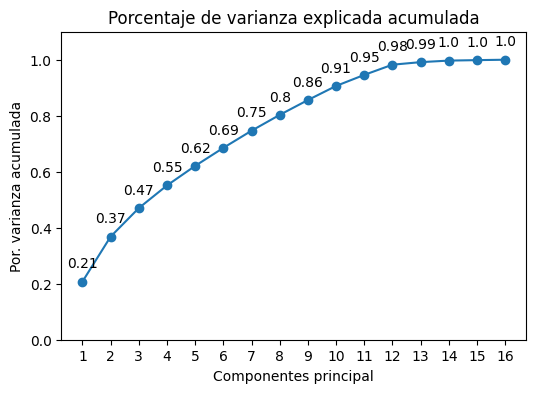

In [51]:
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()

print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(Xt.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(Xt.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componentes principal')
ax.set_ylabel('Por. varianza acumulada');

## Modelos sin hiperparametrizar

In [52]:
models = {
    'PCA_Tree': make_pipeline(StandardScaler(),PCA(n_components=8),DecisionTreeClassifier()),
    'K-best_Tree':make_pipeline(SelectKBest(k=6),DecisionTreeClassifier()) }

In [53]:
for c in models:
    models.get(c).fit(Xt, yt)

In [54]:
for c in models:
    print(c)
    print('Confusion Matrix Train')
    print(confusion_matrix(yt, models.get(c).predict(Xt) ) )
    print('')
    print('Confusion Matrix Test')
    print(confusion_matrix(yv, models.get(c).predict(Xv) ) )
    print('')
    print('Accuracy Train',accuracy_score(yt, models.get(c).predict(Xt)))
    print('Accuracy Test',accuracy_score(yv, models.get(c).predict(Xv))) 
    print('')
    print('Precision Train',precision_score(yt, models.get(c).predict(Xt)))
    print('Precision Test',precision_score(yv, models.get(c).predict(Xv))) 
    print('')
    print('Recall Train',recall_score(yt, models.get(c).predict(Xt)))
    print('Recall Test',recall_score(yv, models.get(c).predict(Xv))) 
    print('')
    print('f1 Train',f1_score(yt, models.get(c).predict(Xt)))
    print('f1 Test',f1_score(yv, models.get(c).predict(Xv))) 
    print('\n')

PCA_Tree
Confusion Matrix Train
[[ 5626     0]
 [    1 17858]]

Confusion Matrix Test
[[ 950  599]
 [ 719 4245]]

Accuracy Train 0.9999574196295508
Accuracy Test 0.7976354982343006

Precision Train 1.0
Precision Test 0.8763418662262593

Recall Train 0.9999440058233944
Recall Test 0.8551571313456889

f1 Train 0.9999720021278383
f1 Test 0.8656199021207177


K-best_Tree
Confusion Matrix Train
[[ 3387  2239]
 [ 1058 16801]]

Confusion Matrix Test
[[ 900  649]
 [ 368 4596]]

Accuracy Train 0.8596125186289121
Accuracy Test 0.8438507600184247

Precision Train 0.8824054621848739
Precision Test 0.8762631077216396

Recall Train 0.9407581611512402
Recall Test 0.9258662369057212

f1 Train 0.9106479850402449
f1 Test 0.9003820158683515




In [55]:
yt.value_counts()

1    17859
0     5626
Name: tgt, dtype: int64

In [63]:
yt.value_counts()[0]/yt.value_counts()[1]

0.3150232375832913

## Modelos con hiper-parametrizacion Random

In [59]:
tree_params = {
    'min_samples_leaf': [i for i in range(50, 500, 50)],
    'max_depth': [i for i in range(5, 10)],
    'criterion': ['gini', 'entropy'],
    'class_weight':[{1:yt.value_counts()[0]/yt.value_counts()[1]}],
    'min_impurity_decrease' : [i for i in np.arange(0.0, 0.9, 0.1)] 
}

In [60]:
models = {
    
    'PCA_Tree': make_pipeline(StandardScaler(),PCA(n_components=8),GridSearchCV(DecisionTreeClassifier(),
                                                   param_grid=tree_params, # Parámetros
                                                   scoring=make_scorer(f1_score), # Métrica para la evaluación
                                                   n_jobs=-1, # Número de trabajos que realizará 
                                                   cv=3, # Cross Validation
                                                   verbose=1, # Nivel para imprimir el proceso
                                                  )),
    'K-best_Tree':make_pipeline(SelectKBest(k=6),
                                GridSearchCV(DecisionTreeClassifier(),
                                                   param_grid=tree_params, # Parámetros
                                                   scoring=make_scorer(f1_score), # Métrica para la evaluación
                                                   n_jobs=-1, # Número de trabajos que realizará 
                                                   cv=3, # Cross Validation
                                                   verbose=1, # Nivel para imprimir el proceso
                                                  )) }

In [61]:
%%time 
for c in models:
    models.get(c).fit(Xt, yt)

Fitting 3 folds for each of 810 candidates, totalling 2430 fits
Fitting 3 folds for each of 810 candidates, totalling 2430 fits
CPU times: user 6.37 s, sys: 1.09 s, total: 7.46 s
Wall time: 1min 25s


In [62]:
for c in models:
    print(c)
    print('Confusion Matrix Train')
    print(confusion_matrix(yt, models.get(c).predict(Xt) ) )
    print('')
    print('Confusion Matrix Test')
    print(confusion_matrix(yv, models.get(c).predict(Xv) ) )
    print('')
    print('Accuracy Train',accuracy_score(yt, models.get(c).predict(Xt)))
    print('Accuracy Test',accuracy_score(yv, models.get(c).predict(Xv))) 
    print('')
    print('Precision Train',precision_score(yt, models.get(c).predict(Xt)))
    print('Precision Test',precision_score(yv, models.get(c).predict(Xv))) 
    print('')
    print('Recall Train',recall_score(yt, models.get(c).predict(Xt)))
    print('Recall Test',recall_score(yv, models.get(c).predict(Xv))) 
    print('')
    print('f1 Train',f1_score(yt, models.get(c).predict(Xt)))
    print('f1 Test',f1_score(yv, models.get(c).predict(Xv))) 
    print('\n')

PCA_Tree
Confusion Matrix Train
[[ 4913   713]
 [ 4166 13693]]

Confusion Matrix Test
[[1355  194]
 [1169 3795]]

Accuracy Train 0.7922503725782414
Accuracy Test 0.7907262398280362

Precision Train 0.9505067333055671
Precision Test 0.9513662572073202

Recall Train 0.7667282602609329
Recall Test 0.7645044319097501

f1 Train 0.8487835115450179
f1 Test 0.8477605271975873


K-best_Tree
Confusion Matrix Train
[[ 4797   829]
 [ 4198 13661]]

Confusion Matrix Test
[[1331  218]
 [1143 3821]]

Accuracy Train 0.7859484777517565
Accuracy Test 0.7910333179794258

Precision Train 0.9427881297446515
Precision Test 0.9460262441198316

Recall Train 0.7649364466095526
Recall Test 0.7697421434327155

f1 Train 0.8446010695848404
f1 Test 0.8488281683883149




## Modelos con Hiperparametrizacion Grid

**Ya que sabemos que nos importa no equivocarnos en la cantidad de personas que elijamos entonces optamos por optimizar la precision**

In [68]:
models = {
    
    'PCA_Tree': make_pipeline(StandardScaler(),PCA(n_components=8),GridSearchCV(DecisionTreeClassifier(),
                                                   param_grid=tree_params, # Parámetros
                                                   scoring=make_scorer(precision_score), # Métrica para la evaluación
                                                   n_jobs=-1, # Número de trabajos que realizará 
                                                   cv=3, # Cross Validation
                                                   verbose=1, # Nivel para imprimir el proceso
                                                  )),
    'K-best_Tree':make_pipeline(SelectKBest(k=6),
                                GridSearchCV(DecisionTreeClassifier(),
                                                   param_grid=tree_params, # Parámetros
                                                   scoring=make_scorer(precision_score), # Métrica para la evaluación
                                                   n_jobs=-1, # Número de trabajos que realizará 
                                                   cv=3, # Cross Validation
                                                   verbose=1, # Nivel para imprimir el proceso
                                                  )) }

In [69]:
%%time 
for c in models:
    models.get(c).fit(Xt, yt)

Fitting 3 folds for each of 810 candidates, totalling 2430 fits
Fitting 3 folds for each of 810 candidates, totalling 2430 fits
CPU times: user 8.42 s, sys: 1.32 s, total: 9.73 s
Wall time: 1min 43s


In [70]:
for c in models:
    print(c)
    print('Confusion Matrix Train')
    print(confusion_matrix(yt, models.get(c).predict(Xt) ) )
    print('')
    print('Confusion Matrix Test')
    print(confusion_matrix(yv, models.get(c).predict(Xv) ) )
    print('')
    print('Accuracy Train',accuracy_score(yt, models.get(c).predict(Xt)))
    print('Accuracy Test',accuracy_score(yv, models.get(c).predict(Xv))) 
    print('')
    print('Precision Train',precision_score(yt, models.get(c).predict(Xt)))
    print('Precision Test',precision_score(yv, models.get(c).predict(Xv))) 
    print('')
    print('Recall Train',recall_score(yt, models.get(c).predict(Xt)))
    print('Recall Test',recall_score(yv, models.get(c).predict(Xv))) 
    print('')
    print('f1 Train',f1_score(yt, models.get(c).predict(Xt)))
    print('f1 Test',f1_score(yv, models.get(c).predict(Xv))) 
    print('\n')

PCA_Tree
Confusion Matrix Train
[[ 4913   713]
 [ 4166 13693]]

Confusion Matrix Test
[[1355  194]
 [1169 3795]]

Accuracy Train 0.7922503725782414
Accuracy Test 0.7907262398280362

Precision Train 0.9505067333055671
Precision Test 0.9513662572073202

Recall Train 0.7667282602609329
Recall Test 0.7645044319097501

f1 Train 0.8487835115450179
f1 Test 0.8477605271975873


K-best_Tree
Confusion Matrix Train
[[ 4797   829]
 [ 4198 13661]]

Confusion Matrix Test
[[1331  218]
 [1143 3821]]

Accuracy Train 0.7859484777517565
Accuracy Test 0.7910333179794258

Precision Train 0.9427881297446515
Precision Test 0.9460262441198316

Recall Train 0.7649364466095526


Recall Test 0.7697421434327155

f1 Train 0.8446010695848404
f1 Test 0.8488281683883149




In [71]:
model = models.get('K-best_Tree')[1].best_estimator_

In [72]:
model 

DecisionTreeClassifier(class_weight={1: 0.3150232375832913},
                       criterion='entropy', max_depth=6, min_samples_leaf=50)

In [73]:
tree_params

{'min_samples_leaf': [50, 100, 150, 200, 250, 300, 350, 400, 450],
 'max_depth': [5, 6, 7, 8, 9],
 'criterion': ['gini', 'entropy'],
 'class_weight': [{1: 0.3150232375832913}],
 'min_impurity_decrease': [0.0,
  0.1,
  0.2,
  0.30000000000000004,
  0.4,
  0.5,
  0.6000000000000001,
  0.7000000000000001,
  0.8]}

In [74]:
model.criterion

'entropy'

In [75]:
kbest = SelectKBest(k=6)
kbest.fit(Xt,yt)

SelectKBest(k=6)

In [76]:
Xt_kbest = kbest.transform(Xt)
Xv_kbest = kbest.transform(Xv)

In [77]:
best = kbest.get_feature_names_out()

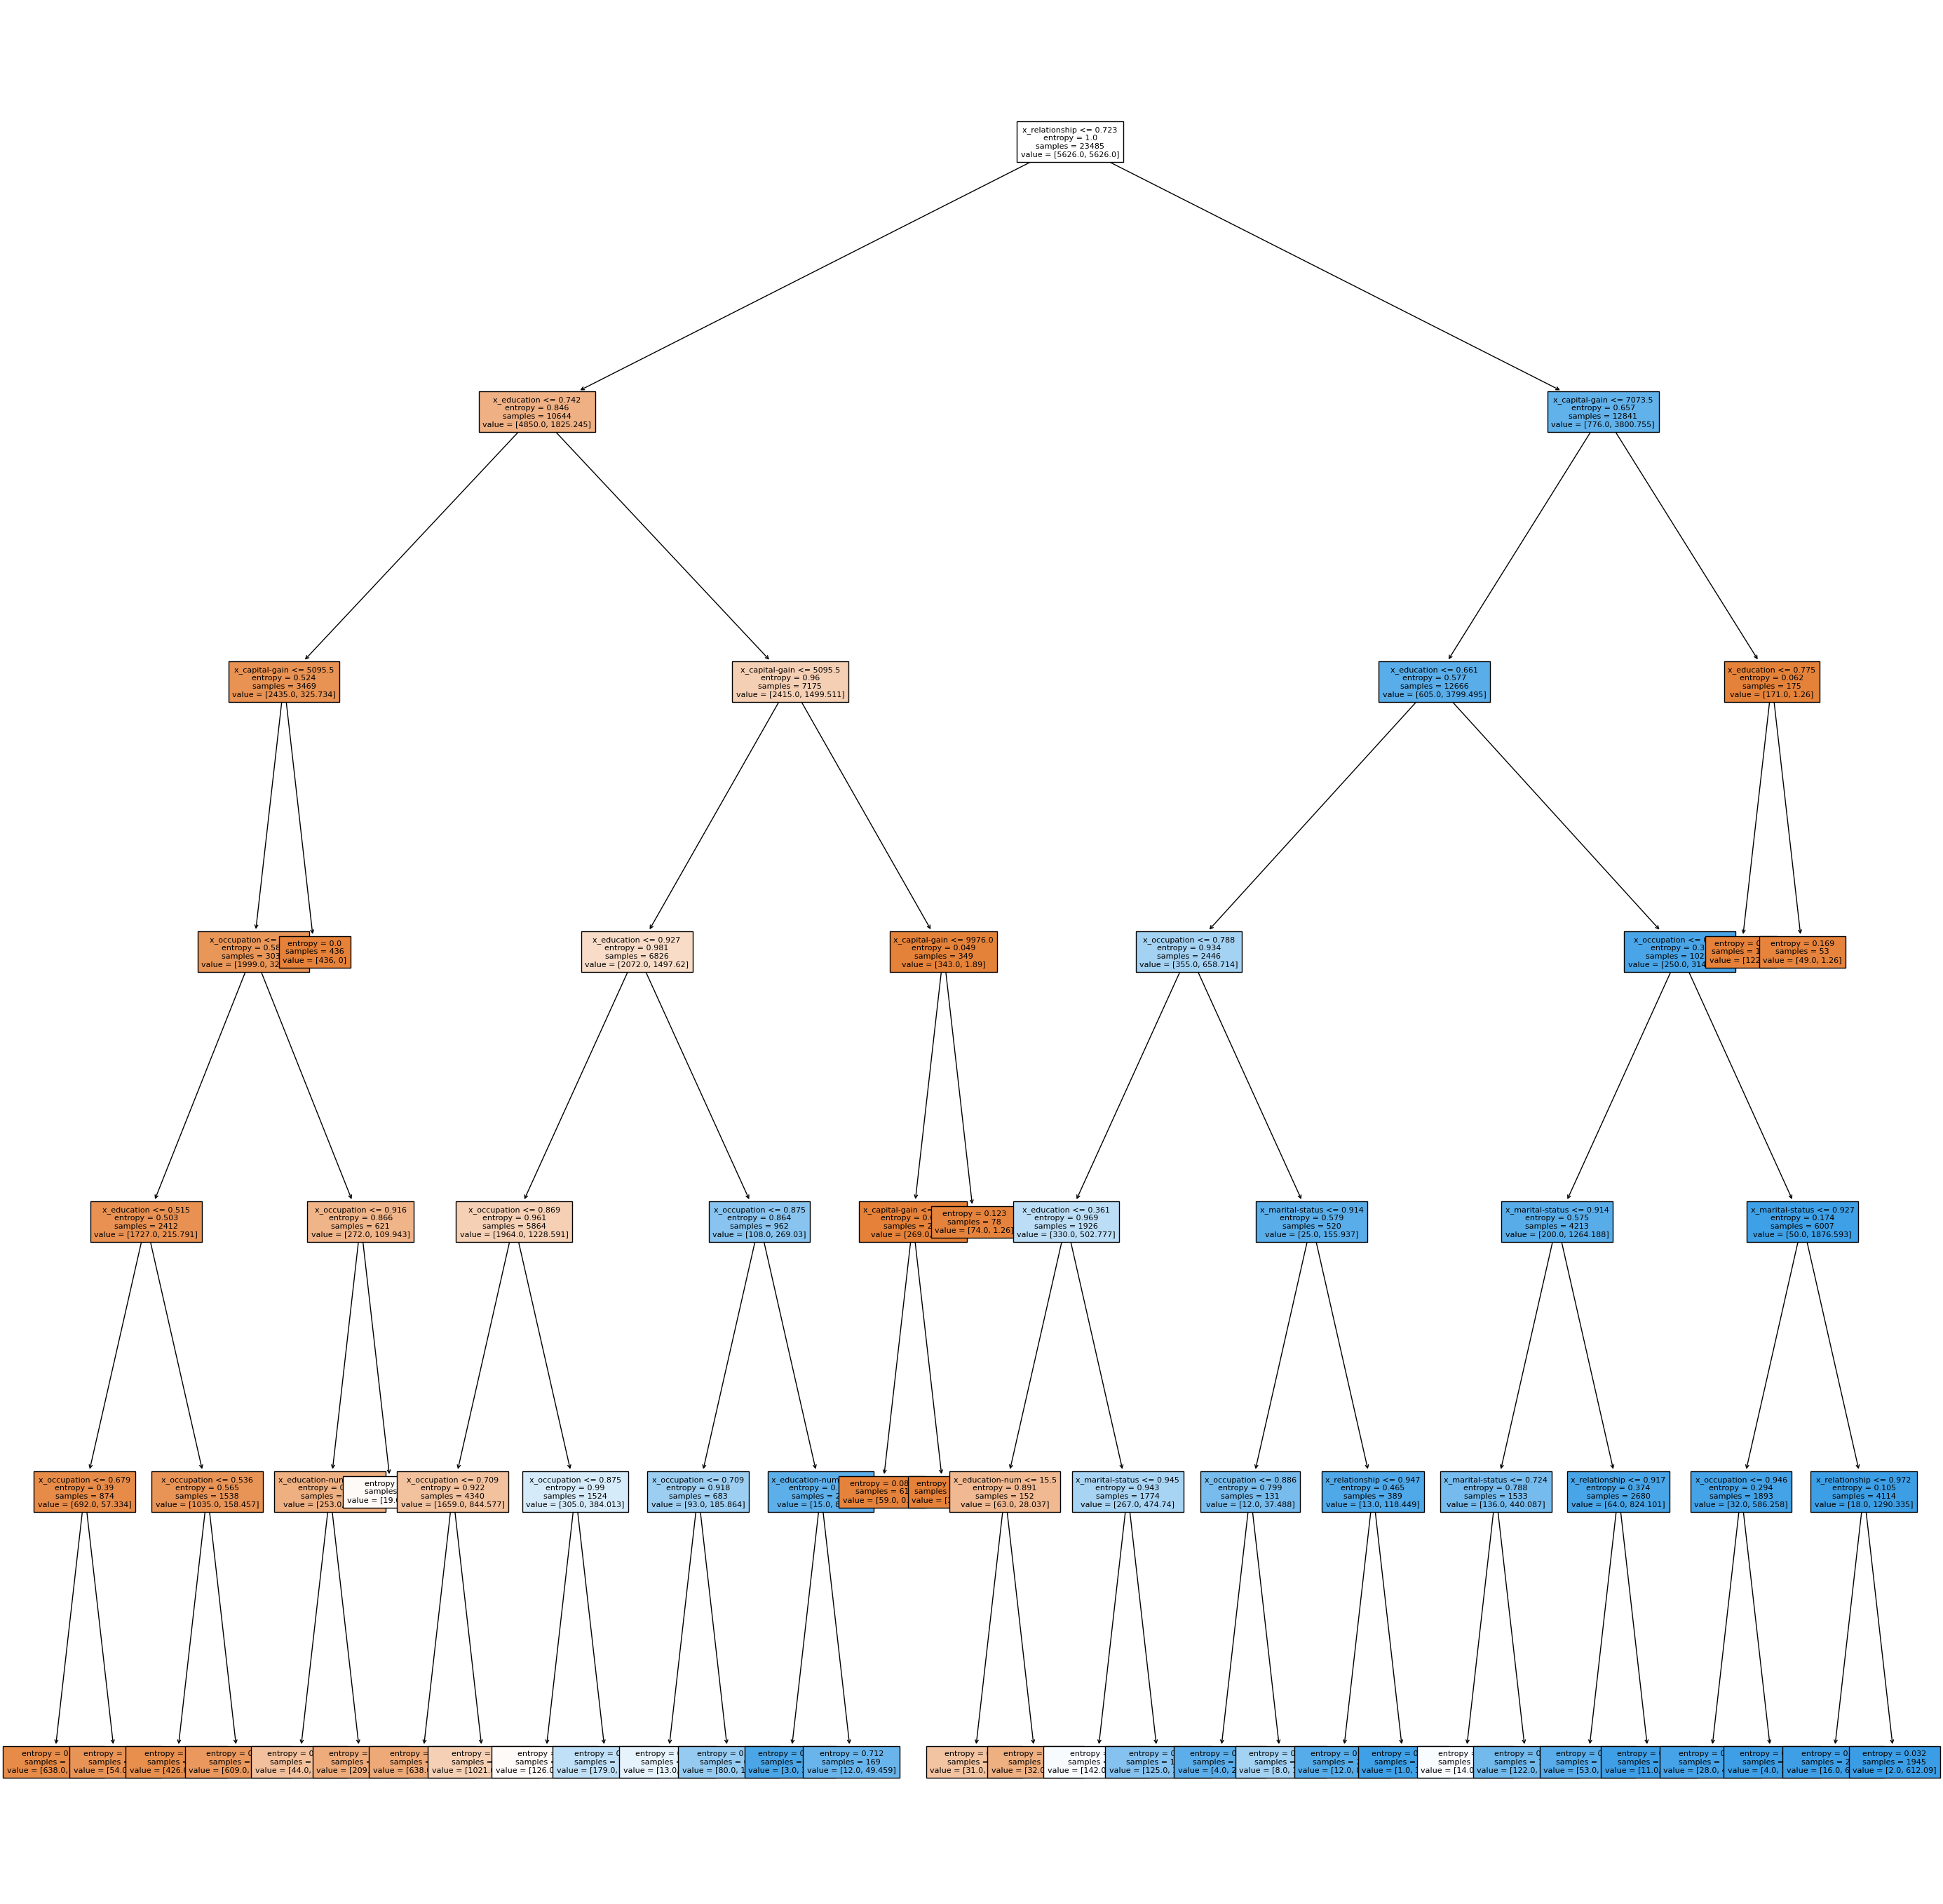

In [78]:
fig = plt.figure(figsize=(35,35))
_ = tree.plot_tree(model,feature_names=best,filled=True, fontsize=8)

## f1 optimo

In [79]:
import matplotlib.pyplot as plt
precision_recall_curve

<function sklearn.metrics._ranking.precision_recall_curve(y_true, probas_pred, *, pos_label=None, sample_weight=None)>

In [80]:
y_scores_ = model.predict_proba(Xt_kbest)
precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(yt, y_scores_[:,1])

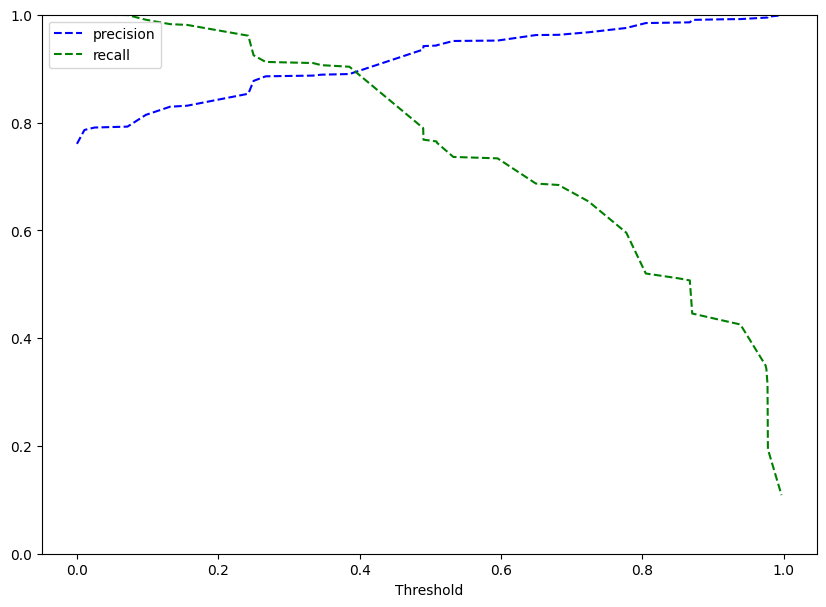

In [81]:
# Graficamos las precisiones y las recuperaciones
plt.figure(figsize=(10,7))
plt.plot(thresholds_lg, precisions_lg[:-1], 'b--', label='precision')
plt.plot(thresholds_lg, recalls_lg[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

In [82]:
def opt_thrsh(model, X, y):
    
    y_scores_ = model.predict_proba(X)
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores_[:,1])
    df = pd.DataFrame()
    df['thrsh'] = thresholds
    df['precision'] = precisions[:-1]
    df['recall'] = recalls[:-1]
    df['diff'] = np.abs(df['precision']-df['recall'])
    
    
    return(float(df.sort_values(by='diff', ascending=True).head(1)['thrsh']))
    

In [83]:
thrsh = opt_thrsh(model,Xt_kbest , yt) 
thrsh

0.38547367209904954

In [84]:
print('f1 Train',f1_score(yt, np.where(model.predict_proba(Xt_kbest)[:,1]>=thrsh,1,0) ))
print('f1 Test', f1_score(yv, np.where(model.predict_proba(Xv_kbest)[:,1]>=thrsh,1,0) ))

f1 Train 0.8966935259794387
f1 Test 0.8939424431475146


## Perfilamiento del modelo

In [85]:
model.fit(Xt_kbest,yt)

DecisionTreeClassifier(class_weight={1: 0.3150232375832913},
                       criterion='entropy', max_depth=6, min_samples_leaf=50)

**Ya que sabemos que el objetivo es repartir el apoyo economico solo a personas que cumplan con el criterio de ganar menos de 50k dolares al año, entonces buscamos evitar los Falsos Positivos**

In [86]:
thrsh

0.38547367209904954

In [87]:
final = Xv.merge(yv,left_index=True, right_index=True)
final.insert(final.shape[1], 'y^',np.where(model.predict_proba(Xv_kbest)[:,1]>=thrsh,1,0) )
final.insert(final.shape[1], 'predict_proba',list(map(lambda x: x[1],model.predict_proba(Xv_kbest) ) )) 

In [88]:
final

,x_age,x_fnlwgt,x_age_exp,x_education-num,x_capital-gain,x_capital-loss,x_hours-per-week,x_workclass,x_education,x_marital-status,x_occupation,x_relationship,x_race,x_sex,x_native-country,x_capital,tgt,y^,predict_proba
0,21,494638,0.363636,12,0,0,15,0.894486,0.741007,0.953814,0.894986,0.986379,0.743421,0.692449,0.753726,0,1,1,0.996743
1,19,35245,0.321429,9,0,0,40,0.781467,0.841209,0.953814,0.805164,0.986379,0.743421,0.692449,0.753726,0,1,1,0.977529
2,22,229456,0.312500,10,0,0,35,0.781467,0.807949,0.953814,0.864669,0.986379,0.874406,0.890980,0.753726,0,1,1,0.996743
3,48,39530,0.157895,9,0,0,40,0.781467,0.841209,0.895793,0.864669,0.896583,0.743421,0.890980,0.753726,0,1,1,0.938570
4,47,144351,0.160714,9,0,625,40,0.781467,0.841209,0.895793,0.771755,0.936755,0.743421,0.692449,0.753726,1,1,1,0.777208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,38,195686,0.208333,10,0,0,40,0.781467,0.807949,0.551401,0.771755,0.549327,0.743421,0.692449,0.753726,0,0,1,0.385474
6509,43,168071,0.173077,9,0,0,44,0.781467,0.841209,0.551401,0.516477,0.549327,0.743421,0.692449,0.753726,0,1,0,0.242402
6510,54,118793,0.142857,9,0,0,45,0.781467,0.841209,0.551401,0.864669,0.549327,0.743421,0.692449,0.753726,0,1,1,0.385474
6511,51,101119,0.150000,9,0,0,70,0.702281,0.841209,0.551401,0.666008,0.549327,0.743421,0.692449,0.753726,0,1,0,0.242402


In [89]:
final.loc[(final['tgt']==0)  & (final['y^']==1)] 

,x_age,x_fnlwgt,x_age_exp,x_education-num,x_capital-gain,x_capital-loss,x_hours-per-week,x_workclass,x_education,x_marital-status,x_occupation,x_relationship,x_race,x_sex,x_native-country,x_capital,tgt,y^,predict_proba
7,31,319146,0.261905,11,4386,0,40,0.781467,0.742857,0.551401,0.771755,0.549327,0.743421,0.692449,0.943137,2,0,1,0.385474
27,64,84737,0.123288,9,0,0,35,0.702281,0.841209,0.551401,0.955944,0.549327,0.727932,0.692449,0.753726,0,0,1,0.595063
33,41,421871,0.180000,9,0,0,40,0.781467,0.841209,0.551401,0.771755,0.549327,0.874406,0.692449,0.753726,0,0,1,0.385474
38,40,155972,0.183673,9,0,0,60,0.781467,0.841209,0.551401,0.805164,0.549327,0.743421,0.692449,0.753726,0,0,1,0.385474
53,54,378747,0.100000,6,0,0,45,0.781467,0.931398,0.937046,0.805164,0.936755,0.874406,0.692449,0.753726,0,0,1,0.977529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458,32,127384,0.255814,11,0,0,55,0.781467,0.742857,0.551401,0.771755,0.549327,0.743421,0.692449,0.753726,0,0,1,0.385474
6459,30,343789,0.250000,10,0,0,40,0.724008,0.807949,0.551401,0.864669,0.549327,0.743421,0.692449,0.753726,0,0,1,0.385474
6488,50,220640,0.218750,14,0,0,50,0.702281,0.449488,0.895793,0.554782,0.896583,0.904000,0.890980,0.753726,0,0,1,0.509382
6505,55,199067,0.140625,9,0,0,40,0.781467,0.841209,0.551401,0.771755,0.549327,0.743421,0.692449,0.753726,0,0,1,0.385474


In [90]:
final 

,x_age,x_fnlwgt,x_age_exp,x_education-num,x_capital-gain,x_capital-loss,x_hours-per-week,x_workclass,x_education,x_marital-status,x_occupation,x_relationship,x_race,x_sex,x_native-country,x_capital,tgt,y^,predict_proba
0,21,494638,0.363636,12,0,0,15,0.894486,0.741007,0.953814,0.894986,0.986379,0.743421,0.692449,0.753726,0,1,1,0.996743
1,19,35245,0.321429,9,0,0,40,0.781467,0.841209,0.953814,0.805164,0.986379,0.743421,0.692449,0.753726,0,1,1,0.977529
2,22,229456,0.312500,10,0,0,35,0.781467,0.807949,0.953814,0.864669,0.986379,0.874406,0.890980,0.753726,0,1,1,0.996743
3,48,39530,0.157895,9,0,0,40,0.781467,0.841209,0.895793,0.864669,0.896583,0.743421,0.890980,0.753726,0,1,1,0.938570
4,47,144351,0.160714,9,0,625,40,0.781467,0.841209,0.895793,0.771755,0.936755,0.743421,0.692449,0.753726,1,1,1,0.777208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,38,195686,0.208333,10,0,0,40,0.781467,0.807949,0.551401,0.771755,0.549327,0.743421,0.692449,0.753726,0,0,1,0.385474
6509,43,168071,0.173077,9,0,0,44,0.781467,0.841209,0.551401,0.516477,0.549327,0.743421,0.692449,0.753726,0,1,0,0.242402
6510,54,118793,0.142857,9,0,0,45,0.781467,0.841209,0.551401,0.864669,0.549327,0.743421,0.692449,0.753726,0,1,1,0.385474
6511,51,101119,0.150000,9,0,0,70,0.702281,0.841209,0.551401,0.666008,0.549327,0.743421,0.692449,0.753726,0,1,0,0.242402


In [91]:
l = final['predict_proba'].unique()
l.sort()
l

array([0.        , 0.01056592, 0.01674318, 0.02507144, 0.07151871,
       0.09744499, 0.13170163, 0.15588221, 0.2424018 , 0.24987475,
       0.26699416, 0.33385441, 0.34573218, 0.38547367, 0.48981435,
       0.49022504, 0.50861794, 0.50938199, 0.53247656, 0.5950633 ,
       0.64921654, 0.68134805, 0.72364034, 0.77720817, 0.80474676,
       0.85008436, 0.86702811, 0.87047464, 0.9182728 , 0.93856976,
       0.97422866, 0.97537805, 0.97695338, 0.97752902, 0.99674315])

**Suponemos que solo podemos entregar 2,000 apoyos**

In [92]:
entrega = final.sort_values('predict_proba', ascending=False).head(2500)

In [93]:
entrega 

,x_age,x_fnlwgt,x_age_exp,x_education-num,x_capital-gain,x_capital-loss,x_hours-per-week,x_workclass,x_education,x_marital-status,x_occupation,x_relationship,x_race,x_sex,x_native-country,x_capital,tgt,y^,predict_proba
0,21,494638,0.363636,12,0,0,15,0.894486,0.741007,0.953814,0.894986,0.986379,0.743421,0.692449,0.753726,0,1,1,0.996743
4915,21,211601,0.322581,10,0,0,40,0.781467,0.807949,0.953814,0.864669,0.986379,0.874406,0.890980,0.753726,0,1,1,0.996743
1432,20,210474,0.333333,10,0,0,15,0.894486,0.807949,0.953814,0.894986,0.986379,0.743421,0.890980,0.753726,0,1,1,0.996743
1435,18,266681,0.280000,7,0,0,20,0.781467,0.947255,0.953814,0.955944,0.986379,0.743421,0.692449,0.753726,0,1,1,0.996743
1438,23,381741,0.342857,12,0,1721,20,0.894486,0.741007,0.953814,0.894986,0.986379,0.743421,0.692449,0.753726,1,1,1,0.996743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4708,57,134286,0.149254,10,0,0,35,0.707006,0.807949,0.937046,0.727706,0.896583,0.743421,0.692449,0.753726,0,1,1,0.867028
4651,43,180138,0.173077,9,0,0,45,0.781467,0.841209,0.953814,0.771755,0.896583,0.743421,0.692449,0.753726,0,1,1,0.867028
6238,25,204536,0.264706,9,0,0,35,0.781467,0.841209,0.953814,0.771755,0.896583,0.743421,0.692449,0.753726,0,1,1,0.867028
3346,26,176146,0.103448,3,0,0,35,0.781467,0.951673,0.937046,0.771755,0.896583,0.898148,0.692449,0.943137,0,1,1,0.867028
